# Week 3: Basic Document Classification (Part 2)

## Preliminaries 

In [ ]:
#necessary library imports and setup introduced previously

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')

import sys
#sys.path.append(r'T:\Departments\Informatics\LanguageEngineering') 
#sys.path.append(r'\\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources')
#sys.path.append(r'/Users/juliewe/resources')
sys.path.append('/content/drive/My Drive/NLE Notebooks/resources/')

import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.tokenize import word_tokenize


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#download nltk resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Overview 
In labs this week (and next), the focus is on the application of sentiment analysis. You have started using the **Amazon review corpus** and exploring various techniques that can be used to classify the sentiment of Amazon book reviews as either positive or negative. 

Last time, you developed your own **Word List** classifiers.  This time you will be developing a **Naïve Bayes** classifiers.

## Naïve Bayes classifiers

We will introduce Naïve Bayes classifiers through a very simple example dataset involving documents that are either about the weather or football. The classifier will be trained to distinguish these two topics from one another.

There are, therefore, two classes `weather` and `football`. The classifier's job is to determine whether a document that it is given is in the class `weather` or in the class `football`.

We give the classifier examples of documents in the `weather` class, and examples of documents in the `football` class. For now, to keep things simple, our so-called documents will be very short phrases.

Run the following cell to set up some training data.

In [ ]:
# Some sentence data to get us started. It is deliberately VERY simple. 

weather_sents_train = [
    "today it is raining",
    "looking cloudy today",
    "it is nice weather",
]

football_sents_train = [
    "city looking good",
    "advantage united",
]

### Assumptions
One of the simplying assumptions that is made with Naïve Bayes classification is that each document is taken to be a so-called **bag of words**. What this means is that the word order is ignored. For example, the document phrase "city looking good" will generate the same *bag* of words as "good looking city" and "good city looking"

The second assumption that we make is that we use the **multi-variate Bernouilli event model**.   This means that we do not taking into account the number of times a word appears in a document.   Each variable (i.e., word) has two possible values -- `True` if it occurs and `False` if it does not.  Note that there are **multinomial** variants of Naïve Bayes where the number of times a words appears in a document is taken into account, but we will not consider that case here.

Given these assumptions, we will represent each training document as a pair consisting of a dictionary that maps each word that appears in the document to `True`, and a string denoting the class of the document. 

### Exercise 1.1
In the cell below, write code that achieves this. Create three lists:
- `weather_data_train`: a dictionary containing the data for documents in the class `weather`;
- `football_data_train`: a dictionary containing the data for documents in the class `football`;
- `train_data`: which is simply `weather_data_train + football_data_train`

For example, `weather_data_train` should look like:

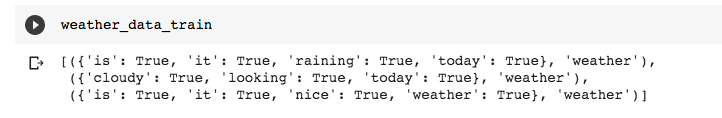

Hint: this can be done with nested list/dictionary comprehensions.

In [ ]:
weather_data_train=[({word:True for word in sent.split()},"weather") for sent in weather_sents_train]

In [ ]:
weather_data_train

[({'is': True, 'it': True, 'raining': True, 'today': True}, 'weather'),
 ({'cloudy': True, 'looking': True, 'today': True}, 'weather'),
 ({'is': True, 'it': True, 'nice': True, 'weather': True}, 'weather')]

In [ ]:
football_data_train=[({word:True for word in sent.split()},"football") for sent in football_sents_train]

NameError: ignored

In [ ]:
train_data=weather_data_train+football_data_train
train_data

[({'is': True, 'it': True, 'raining': True, 'today': True}, 'weather'),
 ({'cloudy': True, 'looking': True, 'today': True}, 'weather'),
 ({'is': True, 'it': True, 'nice': True, 'weather': True}, 'weather'),
 ({'city': True, 'good': True, 'looking': True}, 'football'),
 ({'advantage': True, 'united': True}, 'football')]

### How a Naïve Bayes classifier works

We will now look at how a NB classifier works, using our `weather` versus `football` classification task.

In order to classify a document, $d$, we need to determine which of these probabilities is greatest:

$$P(\,\mbox{weather}\,|\,d) \qquad\qquad \mbox{versus} \qquad\qquad P(\,\mbox{football}\,|\,d)$$

$d$ could, for example, be the string "today is looking cloudy", which would give us:

$$P(\,\mbox{weather}\,|\,\mbox{"today is looking cloudy"}) \qquad\qquad \mbox{versus} \qquad\qquad P(\,\mbox{football}\,|\,\mbox{"today is looking cloudy"})$$

The idea is that if the term on the left is higher then the document is in category `weather`, and if the term on the right is higher then the document is in category `football`.

$P(X|Y)$ means the probability of $X$ given $Y$. So, $P(\,\mbox{weather}\,|\,d)$ means the probability, given a document $d$, of $d$ being of class `weather`.

We are going to use something called Bayes' rule which states that:

$$P(X|Y) = \frac{P(Y|X)\cdot P(X)}{P(Y)}$$

Applying Bayes' rule to our problem leads to the following comparision:

$$\frac{P(\,d\,|\,\mbox{weather}\,)\cdot P(\,\mbox{weather}\,)}{p(d)} \qquad\qquad \mbox{versus} \qquad\qquad \frac{P(\,d\,|\,\mbox{football}\,)\cdot P(\,\mbox{football}\,)}{p(d)}$$

Since both sides are being divided by the same thing, we only need to make the following comparision:

$$P(\,d\,|\,\mbox{weather}\,)\cdot P(\,\mbox{weather}\,) \qquad\qquad \mbox{versus} \qquad\qquad P(\,d\,|\,\mbox{football}\,)\cdot P(\,\mbox{football}\,)$$

Let's just look at what each of these probabilities mean?

1. $P(\,d\,|\,\mbox{weather}\,)$: this is the probability of a document in the `weather` category being the document $d$

2. $P(\,d\,|\,\mbox{football}\,)$: this is the probability of a document in the `football` category being the document $d$

3. $P(\,\mbox{weather}\,)$: this is the probability of a randomly selected document being of category `weather`.

4. $P(\,\mbox{football}\,)$: this is the probability of a randomly selected document being of category `football`.

How are we going to obtain these probabilities? 


### Class priors

We have established that we need to know $P(\,\mbox{weather}\,)$ and $P(\,\mbox{football}\,)$. These are called the class priors. Let's see how we can obtain (estimated) values for these probabilities from our training data.

The classifier has seen three documents of class `weather` and two documents of class `football`.

From this it learns that `weather` documents are slightly more common that `football` documents, and it therefore has a slight bias towards saying a document is a `weather` document.

To be more precise, the classifier has learned that:
- The probability that a document is in class `weather` is $3/5$.  
We say $P(\mbox{weather})=3/5=0.6$.

- The probability that a document is in class `football` is $2/5$.  
We say $P(\mbox{football})=2/5=0.4$.

In general, if the training data contained $n_1$ documents of class `weather` and $n_2$ documents of class `football`, then 

$$P(\mbox{weather})=\frac{n_1}{n_1+n_2} \qquad \mbox{and} \qquad P(\mbox{football})=\frac{n_2}{n_1+n_2}$$

### Exercise 1.2
In blank the cell below, implement a function `class_priors(training_data)` that takes a dictionary of training data  and returns a dictionary that maps the name of each class to the class prior for that class.

Once you have done this, test it out on the training data above.

In [ ]:
def class_priors(training_data):
    priors={}
    for (doc,label) in training_data:
        priors[label]=priors.get(label,0)+1
    total=sum(priors.values())
    for key,value in priors.items():
        priors[key]=value/total
    return priors
        

In [ ]:
class_priors(train_data)

{'football': 0.4, 'weather': 0.6}

### Conditional probabilities
We now turn to the problem of how to calculate (estimates of) the probabilities such as $P(\,d\,|\,\mbox{weather}\,)$ and $P(\,d\,|\,\mbox{football}\,)$, for some document $d$. The problem we have is that $d$ is a document, potentially a long document, that we won't have seen in the training data.

To address this, the Naïve Bayes model of document classification makes a major simplifying assumption.  In particular, it is assumed that the probabiity that different words occur in a document are independent of one another.

For example, if $d=\mbox{"today is looking cloudy"}$ then this assumption tells us that:

\begin{eqnarray*}
P(\,\mbox{"today is looking cloudy"}\,|\,\mbox{weather}\,) &=& P(\{\mbox{"today"},\mbox{"is"},\mbox{"looking"},\mbox{"cloudy"}\}\,|\,\mbox{weather}\,)\\
&=& P(\,\mbox{"today"}\,|\,\mbox{weather}\,)\times P(\mbox{"is"}\,|\,\mbox{weather}\,)\times P(\mbox{"looking"}\,|\,\mbox{weather}\,)\times P(\mbox{"cloudy"}\,|\,\mbox{weather}\,)
\end{eqnarray*}

For the general case, with class $c$ and document $d=\{w_1,\ldots,w_n\}$, we have:
\begin{eqnarray*}
P(\,d\,|\,c\,) &=& P(\,\{w_1,\ldots,w_n\}\,|\,c\,)\\
&=& \prod_{i=1}^n P(\,w_i\,|\,c\,)
\end{eqnarray*}

The point is that it is plausible that given a reasonable amount of training data, we can make reasonable estimates of the probabilities $P(\,\mbox{"today"}\,|\,\mbox{weather}\,)$, $P(\mbox{"is"}\,|\,\mbox{weather}\,)$, $P(\mbox{"looking"}\,|\,\mbox{weather}\,)$, and  $P(\mbox{"cloudy"}\,|\,\mbox{weather}\,)$. 

We now look at how that is done.

### Estimating conditional probabilities
So we have established that we need estimates of probabilities such as: $P(\,\mbox{"cloudy"}\,|\,\mbox{weather}\,)$, $P(\mbox{"is"}\,|\,\mbox{weather}\,)$, $P(\mbox{"today"}\,|\,\mbox{weather}\,)$, and $P(\mbox{"looking"}\,|\,\mbox{weather}\,)$.

How can these probabilities be estimated from the training data?

Look at the training data we set up above. There are 3 documents of class `weather` and within these documents there are a total of 11 tokens (8 different types).

From the data we can estimate the following probabilities:
- the probability of seeing "today" in a `weather` document is $\frac{2}{11}$,  
i.e. $P(\mbox{"today"}\,|\,\mbox{weather})=\frac{2}{11}$;
- the probability of seeing "it" in a `weather` document is $\frac{2}{11}$,  
i.e. $P(\mbox{"it"}\,|\,\mbox{weather})=\frac{2}{11}$;
- the probability of seeing "is" in a `weather` document is $\frac{2}{11}$,  
i.e. $P(\mbox{"is"}\,|\,\mbox{weather})=\frac{2}{11}$;
- the probability of seeing "raining" in a `weather` document is $\frac{1}{11}$,  
i.e. $P(\mbox{"raining"}\,|\,\mbox{weather})=\frac{1}{11}$;
- the probability of seeing "looking" in a `weather` document is $\frac{1}{11}$,  
i.e. $P(\mbox{"looking"}\,|\,\mbox{weather})=\frac{1}{11}$;
- the probability of seeing "cloudy" in a `weather` document is $\frac{1}{11}$,  
i.e. $P(\mbox{"cloudy"}\,|\,\mbox{weather})=\frac{1}{11}$;
- the probability of seeing "nice" in a `weather` document is $\frac{1}{11}$,  
i.e. $P(\mbox{"nice"}\,|\,\mbox{weather})=\frac{1}{11}$; and
- the probability of seeing "weather" in a `weather` document is $\frac{1}{11}$,  
i.e. $P(\mbox{"weather"}\,|\,\mbox{weather})=\frac{1}{11}$
- the probability of seeing any other word in a `weather` document is 0.
Notice that all of these conditional probabilities sum to $1$.

We can do the same thing for the `football` documents:
- the probability of seeing "city" in a `football` document is $\frac{1}{5}$,  
i.e. $P(\mbox{"city"}\,|\,\mbox{weather})=\frac{1}{5}$;
- the probability of seeing "looking" in a `football` document is $\frac{1}{5}$,  
i.e. $P(\mbox{"looking"}\,|\,\mbox{weather})=\frac{1}{5}$;
- the probability of seeing "good" in a `football` document is $\frac{1}{5}$,  
i.e. $P(\mbox{"good"}\,|\,\mbox{weather})=\frac{1}{5}$;
- the probability of seeing "advantage" in a `football` document is $\frac{1}{5}$,  
i.e. $P(\mbox{"advantage"}\,|\,\mbox{weather})=\frac{1}{5}$;
- the probability of seeing "united" in a `football` document is $\frac{1}{5}$,  
i.e. $P(\mbox{"united"}\,|\,\mbox{weather})=\frac{1}{5}$;
- the probability of seeing any other word in a `football` document is 0.


### Exercise 1.3
We now look at how to implement the calculation of conditional probabilties.

In the empty cell below, define a function `cond_probs(training_data)` that takes training data and returns a dictionary that maps the name of a class, $c$, onto a dictionary that maps each word, $w$ to the conditional probability for that word given that class, i.e. $P(w|c)$.



In [ ]:
def cond_probs(training_data):
    conds={}
    for(doc,label) in training_data:
        classcond=conds.get(label,{})
        for word in doc.keys():
            classcond[word]=classcond.get(word,0)+1
        
        conds[label]=classcond
    print(conds)
    for label,dist in conds.items():
        total=sum(dist.values())
        conds[label]={key:value/total for (key,value) in dist.items()}
        
    return conds

In [ ]:
cond_probs(train_data)

{'weather': {'today': 2, 'it': 2, 'is': 2, 'raining': 1, 'looking': 1, 'cloudy': 1, 'nice': 1, 'weather': 1}, 'football': {'city': 1, 'looking': 1, 'good': 1, 'advantage': 1, 'united': 1}}


{'football': {'advantage': 0.2,
  'city': 0.2,
  'good': 0.2,
  'looking': 0.2,
  'united': 0.2},
 'weather': {'cloudy': 0.09090909090909091,
  'is': 0.18181818181818182,
  'it': 0.18181818181818182,
  'looking': 0.09090909090909091,
  'nice': 0.09090909090909091,
  'raining': 0.09090909090909091,
  'today': 0.18181818181818182,
  'weather': 0.09090909090909091}}

### Computing the conditional probability of a document

We have created implementations of the following functions:
- `class_priors(training_data)` that computes estimates of the class priors from training data;
- `cond_probs(training_data)` that computes estimates of the conditional probability of a word given a class from training data

Let us suppose that we have applied these functions to our training data as follows.

```
c_priors = class_priors(train_data)
c_probs = cond_probs(train_data)
```

`c_priors` and `c_probs` define the classifier.

### Exercise 1.4
In the cell below, complete the function `classify(doc,c_priors,c_probs)`. It should return the class that the classifier assigns to the document, `doc`. 

In the event of a tie, the function should randomly chose one of the classes (see `random.choice`). 

- Write your function in a way that allows for the possibilty of any number of classes.
- Assume that the document, `doc`, is represented as a dictionary that maps words (in the document) to `True`.

In [ ]:
import random
def classify(doc,priors,c_probs):

    #<put your definition of classify here>
    doc_probs=priors
    for word in doc.keys():            
        doc_probs={classlabel:sofar*c_probs[classlabel].get(word,0) for (classlabel,sofar) in doc_probs.items()}

    highprob=max(doc_probs.values())
    print(doc_probs.values())
    print(highprob)
    classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
    print(classes)
    return random.choice(classes)
        
c_priors = class_priors(train_data)
c_probs = cond_probs(train_data)
sent = "looking cloudy today"
doc = dict([(word, True) for word in sent.split()])
classify(doc,c_priors,c_probs)

{'weather': {'today': 2, 'it': 2, 'is': 2, 'raining': 1, 'looking': 1, 'cloudy': 1, 'nice': 1, 'weather': 1}, 'football': {'city': 1, 'looking': 1, 'good': 1, 'advantage': 1, 'united': 1}}
dict_values([0.0009015777610818934, 0.0])
0.0009015777610818934
['weather']


'weather'

In [ ]:
c_priors

{'football': 0.4, 'weather': 0.6}

### A problem
There is a problem with the classifier that we have written. 

### Exercise 2.1
* Can you find example sentences which give you different answers on different runs of the classifier
* Can you explain why?

In [ ]:
sent = "looking cloudy today united city good"
doc = dict([(word, True) for word in sent.split()])
classify(doc,c_priors,c_probs)

dict_values([0.0, 0.0])
0.0
['weather', 'football']


'weather'

In [ ]:
c_probs

### Add one smoothing
It will often be the case that a word appears in documents of one class, but not in any documents of another class.
- For example, consider the document "city looking cloudy today".
- While "city" appears in documents of class `football`, it does not appear in any documents of class `weather`. 
- Thus, the conditional probabiity $P(\,\mbox{city}\,|\,\mbox{weather}\,)$ is equal to zero.
- We are **multiplying** probabilities, so the document ends up with a score of zero even though all of the other words in the document suggest that it is of class `weather`.

To get around this we need to do something called **smoothing** in order to avoid zero probabilities. 

In particular, we will implement a version of smoothing called **add-one smoothing**. This involves adding a count of one to all of the known vocabulary.

### Known vocabulary
The words that appear in documents in the training data are collectively described as the known vocabulary. These are the words that the classifier can learn something about. If the classifier is asked to classify a document that contains any words that are not in the known vocabulary then the classifier will simply ignore them.

### Exercise 2.2
In the cell below, write a function `known_vocabulary(training_data)` that takes some training and returns a set containing all of words that appear in documents in the training data.

In [ ]:
def known_vocabulary(training_data):
    known=set()
    for doc,label in training_data:
        for word in list(doc.keys()):
          known.add(word)
    return known

In [ ]:
vocab=known_vocabulary(train_data)

In [ ]:
len(vocab)

12

In [ ]:
vocab

{'advantage',
 'city',
 'cloudy',
 'good',
 'is',
 'it',
 'looking',
 'nice',
 'raining',
 'today',
 'united',
 'weather'}

### Implementing add-one smoothing
As the name suggests, add-one smoothing involves adding counts.

In particular, for each word, $w$, in the known vocabulary and each class, $c$, we add one extra count to our record of how many times $w$ appears in documents of class $c$. We are, in effect, hallucinating counts. The reason for doing this is that it means that we avoid zero probabilties.

### Exercise 2.3
In the blank cell below copy in your code for the `cond_probs` function that you wrote earlier. Then adapt this code so that it implements the add-one smoothing scheme.
- You will find it useful to use your `known_vocabulary` function.
- If there are $k$ words in your known vocabulary, then you will add $k$ counts for each class. 
- Therefore, when calculating conditional probabilities, you need to add $k$ to the denominator to account for these extra counts.

Test out your code.

In [ ]:
def cond_probs(training_data):
    conds={}
    for(doc,label) in training_data:
        classcond=conds.get(label,{})
        for word in doc.keys():
            classcond[word]=classcond.get(word,0)+1
        
        conds[label]=classcond
    
    for label, classcond in conds.items():
        for word in known_vocabulary(training_data):
        
            classcond[word]=classcond.get(word,0)+1
        conds[label]=classcond
            
    for label,dist in conds.items():
        total=sum(dist.values())
        conds[label]={key:value/total for (key,value) in dist.items()}
        
    return conds

In [ ]:
cond_probs(train_data)

{'football': {'advantage': 0.11764705882352941,
  'city': 0.11764705882352941,
  'cloudy': 0.058823529411764705,
  'good': 0.11764705882352941,
  'is': 0.058823529411764705,
  'it': 0.058823529411764705,
  'looking': 0.11764705882352941,
  'nice': 0.058823529411764705,
  'raining': 0.058823529411764705,
  'today': 0.058823529411764705,
  'united': 0.11764705882352941,
  'weather': 0.058823529411764705},
 'weather': {'advantage': 0.043478260869565216,
  'city': 0.043478260869565216,
  'cloudy': 0.08695652173913043,
  'good': 0.043478260869565216,
  'is': 0.13043478260869565,
  'it': 0.13043478260869565,
  'looking': 0.08695652173913043,
  'nice': 0.08695652173913043,
  'raining': 0.08695652173913043,
  'today': 0.13043478260869565,
  'united': 0.043478260869565216,
  'weather': 0.08695652173913043}}

### Smoothing class priors
It is possible (though perhaps unlikely) that the training data does not contain any data for one class. In order to take care of this, we can also smooth the class priors.

### Exercise 2.4
In the cell below, revise the `class_priors` function so that it adds one to the count of each class.

Check that the sum of the priors for each of the classes is $1$.

In [ ]:
def class_priors(training_data):
    priors={}
    for (doc,label) in training_data:
        priors[label]=priors.get(label,0)+1
    #print(priors)
    for label,count in priors.items():
      priors[label]=count+1
    #print(priors)
    total=sum(priors.values())
    for key,value in priors.items():
        priors[key]=value/total
    return priors

In [ ]:
class_priors(train_data)

{'weather': 3, 'football': 2}
{'weather': 4, 'football': 3}


{'football': 0.42857142857142855, 'weather': 0.5714285714285714}

### Ignoring OOV words
We now look at how to update the `classify` function that we wrote earlier so that it ignores out of vocabulary words that appear in a document being classified.

### Exercise 2.5
In the blank cell below, copy the `classify` method you wrote earlier and update it so that words not in the known vocabulary are ignored.
- You will want to add an additional argument to the `classify` function that is a set containing the known vocabulary.

In [ ]:
def classify(doc,priors,c_probs,known):

    doc_probs=priors
    for word in doc.keys():
        if word in known:
            doc_probs={classlabel:sofar*c_probs[classlabel].get(word,0) for (classlabel,sofar) in doc_probs.items()}
    print(doc_probs)
    highprob=max(doc_probs.values())
    classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
    print(classes)
    return random.choice(classes)
        
c_priors = class_priors(train_data)
c_probs = cond_probs(train_data)
sent = "looking cloudy today"
doc = dict([(word, True) for word in sent.split()])
classify(doc,c_priors,c_probs,known_vocabulary(train_data))

{'weather': 0.0005635853420845612, 'football': 0.00017446424936756708}
['weather']


'weather'

In [ ]:
sent = "looks cloudy today"
doc = dict([(word, True) for word in sent.split()])
classify(doc,c_priors,c_probs,known_vocabulary(train_data))

{'weather': 0.006481231433972454, 'football': 0.0014829461196243202}
['weather']


'weather'

### Underflow

We need to address one final problem concerning the multiplication of probabilities.

Recall this equation from earlier:

\begin{eqnarray*}
P(\,d\,|\,c\,) &=& P(\,\{w_1,\ldots,w_n\}\,|\,c\,)\\
&=& \prod_{i=1}^n P(\,w_i\,|\,c\,)
\end{eqnarray*}

This tells us that in order to compute $P(\,d\,|\,c\,)$ for some document $d$ and class $c$, we must multiply $n$ conditional probabilities, one for each word in the document.

While in our toy example, this is not an issue. However, in a more realistic settings, where we had thousands of documents, each of which contained multiple paragraphs, we would find ourselves multiplying large numbers of very small probabilities. This would lead to **underflow**.

To avoid ths problem, we will add the log of probabilties. 

To understand why this is a reasonable thing to do let us recall a comparison from earlier:

$$P(\,d\,|\,\mbox{weather}\,)\cdot P(\,\mbox{weather}\,) \qquad\qquad \mbox{versus} \qquad\qquad P(\,d\,|\,\mbox{football}\,)\cdot P(\,\mbox{football}\,)$$

Our goal is to determine which of the values (on the left and right) is larger (or determine that they are equal). 

It should be clear that we will get exactly the same answer to this question by making the following comparsion.

$$\log(P(\,d\,|\,\mbox{weather}\,)) + \log(P(\,\mbox{weather}\,)) \qquad\qquad \mbox{versus} \qquad\qquad \log(P(\,d\,|\,\mbox{football}\,)) + \log(P(\,\mbox{football}\,))$$

Thus, rather than calculating conditional probabilities as described above, we will calculate log conditional probabilities like this:

\begin{eqnarray*}
\log(P(\,\mbox{"today is looking cloudy"}\,|\,\mbox{weather}\,)) &=& \log(P(\{\mbox{"today"},\mbox{"is"},\mbox{"looking"},\mbox{"cloudy"}\}\,|\,\mbox{weather}\,))\\
&=& \log(P(\,\mbox{"today"}\,|\,\mbox{weather}\,))\ +\\
&&\log(P(\mbox{"is"}\,|\,\mbox{weather}\,))\ +\\
&&\log(P(\mbox{"looking"}\,|\,\mbox{weather}\,))\ + \\
&&\log(P(\mbox{"cloudy"}\,|\,\mbox{weather}\,))
\end{eqnarray*}

For the general case, with class $c$ and document $d=\{w_1,\ldots,w_n\}$, we have:

\begin{eqnarray*}
\log(P(\,d\,|\,c\,)) &=& \log(P(\,\{w_1,\ldots,w_n\}\,|\,c\,))\\
&=& \sum_{i=1}^n \log(P(\,w_i\,|\,c\,))
\end{eqnarray*}


### Exercise 2.6
In the blank cell below, make a copy of the cell containing the definition of `classify`.

Adapt the code so that it adds logs of probabilties rather than multiplies probabilities.

In [ ]:
import math
def classify(doc,priors,c_probs,known):

    #<put your definition of classify here>
    doc_probs={key:math.log(value) for (key,value) in priors.items()}
    for word in doc.keys():
        if word in known:
            doc_probs={classlabel:sofar+math.log(c_probs[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

    highprob=max(doc_probs.values())
    classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
    return random.choice(classes)
        
c_priors = class_priors(train_data)
c_probs = cond_probs(train_data)
sent = "looking cloudy today"
doc = dict([(word, True) for word in sent.split()])
classify(doc,c_priors,c_probs,known_vocabulary(train_data))

'weather'

### Constructing a Naïve Bayes classifier

We are now almost ready to run our Naïve Bayes classifier on a set of test data. 

In [ ]:
weather_sents_test = [
    "the weather today is nice",
    "it is raining cats and dogs",
    "the weather here is wet",
    "it was hot today",
    "rain due tomorrow",
]

football_sents_test = [
    "what a great goal that was",
    "poor defending by the city center back",
    "wow he missed a sitter",
    "united are a shambles",
    "shots raining down on the keeper",
]

weather_data_test = [({word: True for word in sent.split()}, "weather") for sent in weather_sents_test] 
football_data_test = [({word: True for word in sent.split()}, "football") for sent in football_sents_test]
test_data = weather_data_test + football_data_test



In [ ]:
test_data

[({'is': True, 'nice': True, 'the': True, 'today': True, 'weather': True},
  'weather'),
 ({'and': True,
   'cats': True,
   'dogs': True,
   'is': True,
   'it': True,
   'raining': True},
  'weather'),
 ({'here': True, 'is': True, 'the': True, 'weather': True, 'wet': True},
  'weather'),
 ({'hot': True, 'it': True, 'today': True, 'was': True}, 'weather'),
 ({'due': True, 'rain': True, 'tomorrow': True}, 'weather'),
 ({'a': True,
   'goal': True,
   'great': True,
   'that': True,
   'was': True,
   'what': True},
  'football'),
 ({'back': True,
   'by': True,
   'center': True,
   'city': True,
   'defending': True,
   'poor': True,
   'the': True},
  'football'),
 ({'a': True, 'he': True, 'missed': True, 'sitter': True, 'wow': True},
  'football'),
 ({'a': True, 'are': True, 'shambles': True, 'united': True}, 'football'),
 ({'down': True,
   'keeper': True,
   'on': True,
   'raining': True,
   'shots': True,
   'the': True},
  'football')]

### Exercise 2.7
* Complete the NBClassifier `class` which can be used to carry out classification.  Add your code (from earlier) to the methods `set_known_vocabulary`, `set_priors` and `set_cond_probs` and `classify`.  
* Run your NB classifier on both the training data and the test data.

In [1]:
class NBClassifier:
    
    def __init__(self):
        
        pass
    
    def _set_known_vocabulary(self,training_data):
        #add your code here
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)
    
    def _set_priors(self,training_data):
        #add your code here 
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors
        
    def _set_cond_probs(self,training_data):       
        #add your code here
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1
        
            conds[label]=classcond
    
        for label, classcond in conds.items():
            for word in self.known:
        
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
            
        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}
        
        self.conds=conds
    
    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)
    
    def classify(self,doc):
        #add your code here
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)
    
    def batch_classify(self,docs):
        return [self.classify(doc) for doc in docs]
    
    

In [2]:
#create an instance of an NBClassifier and apply it to the test data
myclassifier=NBClassifier()
myclassifier.train(train_data)
myclassifier.batch_classify(doc for (doc,label) in test_data)

NameError: ignored